```{contents}
```
## Terminal Node

A **Terminal Node** in LangGraph represents the **logical and executional endpoint** of a graph. It marks the moment when the workflow is **complete**, the final state is produced, and execution **halts deterministically**.

In LangGraph, this is represented by the special symbol:

```python
from langgraph.graph import END
```

---

### **1. Intuition: What Is a Terminal Node?**

Conceptually, a Terminal Node is equivalent to:

* A `return` statement in a program
* The `halt` state in a state machine
* The `final state` of an algorithm

Once the graph reaches the terminal node:

* **No further nodes execute**
* **The current state becomes the output**
* **All resources are released**
* **Execution context is closed**

---

### **2. Role of the Terminal Node in Execution Semantics**

| Property           | Behavior                   |
| ------------------ | -------------------------- |
| Deterministic halt | Graph always stops         |
| State freeze       | No further state updates   |
| Execution boundary | Defines lifecycle end      |
| Result extraction  | Final state is returned    |
| Safety guarantee   | Prevents runaway execution |

---

### **3. How LangGraph Implements Terminal Nodes**

LangGraph uses the constant:

```python
END
```

to represent the terminal node.

It is **not a normal node**:

* It has **no handler**
* It performs **no computation**
* It cannot update state

It only signals **graph termination**.

---

### **4. Minimal Example**

```python
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    text: str
    result: str

def process(state):
    return {"result": state["text"].upper()}

builder = StateGraph(State)

builder.add_node("process", process)
builder.set_entry_point("process")
builder.add_edge("process", END)

graph = builder.compile()
output = graph.invoke({"text": "langgraph"})
print(output)
```

**Execution Flow**

```
process → END
```

Returned state:

```python
{"text": "langgraph", "result": "LANGGRAPH"}
```

---

### **5. Terminal Node with Conditional Routing**

```python
def router(state):
    if "error" in state:
        return END
    return "process"

builder.add_conditional_edges("router", router, {
    "process": "process",
    END: END
})
```

This allows **dynamic termination** based on runtime state.

---

### **6. Terminal Node in Cyclic Graphs**

Terminal nodes are critical for **breaking cycles**.

```python
def should_stop(state):
    return END if state["done"] else "loop"

builder.add_conditional_edges("check", should_stop, {
    "loop": "loop",
    END: END
})
```

Without a terminal node, cyclic graphs would run indefinitely.

---

### **7. Production Semantics**

| Concern          | How Terminal Node Helps        |
| ---------------- | ------------------------------ |
| Resource cleanup | Ensures deterministic shutdown |
| Safety           | Prevents infinite execution    |
| Observability    | Marks execution boundary       |
| Cost control     | Stops token usage              |
| Auditability     | Final state snapshot           |

---

### **8. Mental Model**

The Terminal Node is the **formal definition of completion**.

> **A graph is not finished until it reaches END.**

Every correct LangGraph design must ensure:

1. All possible execution paths reach `END`
2. Cycles are guaranteed to converge to `END`
3. Final state is complete and valid at `END`


In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict

# -------------------------
# 1. Define the State
# -------------------------
class State(TypedDict):
    text: str
    result: str

# -------------------------
# 2. Define Node Logic
# -------------------------
def process_node(state: State):
    return {"result": state["text"].upper()}

# -------------------------
# 3. Build Graph
# -------------------------
builder = StateGraph(State)

builder.add_node("process", process_node)
builder.set_entry_point("process")

# Terminal node connection
builder.add_edge("process", END)

# -------------------------
# 4. Compile & Run
# -------------------------
graph = builder.compile()

output = graph.invoke({"text": "langgraph"})
print(output)


{'text': 'langgraph', 'result': 'LANGGRAPH'}


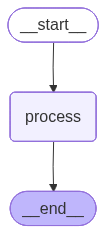

In [2]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    count: int
    done: bool

def increment(state: State):
    return {"count": state["count"] + 1}

def check_done(state: State):
    return {"done": state["count"] >= 3}

def router(state: State):
    return END if state["done"] else "increment"

builder = StateGraph(State)

builder.add_node("increment", increment)
builder.add_node("check", check_done)

builder.set_entry_point("increment")
builder.add_edge("increment", "check")

builder.add_conditional_edges("check", router, {
    "increment": "increment",
    END: END
})

graph = builder.compile()
result = graph.invoke({"count": 0, "done": False})
print(result)


{'count': 3, 'done': True}


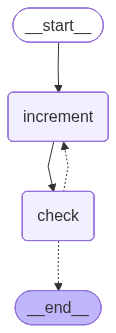

In [4]:
Image(graph.get_graph().draw_mermaid_png())